Example 1: Load one file into the `Resonator` class
======================

**By: Faustin Carter, 2016**

This notebook imports the data from one Agilent file, creates a `Resonator` object, runs a fitting routine, and then plots the data and fit curves in a nice way.

Once you've understood this example, you should be able to replicate it with your own data simply be writing a custom `process_file` function and updating the code that finds the datafile.

In [1]:
#import all the necessary libraries

#For inline notebook figures
%matplotlib inline

#For high-res figures
%config InlineBackend.figure_format = 'retina' 

import glob #For easy file grabbing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs #For plot arrangement
import seaborn as sns #For pretty plots
import pprint as pp #For pretty printing of dicts

#Some code to make plots pretty
sns.set_context("poster") #This makes all the text bigger automatically
sns.set_style("ticks",{"xtick.direction" : u"in","ytick.direction" : u"in"})

Load up the `pyRes` modules
----------
You'll need to change the path to reflect wherever you stored the code

In [2]:
#Change directories up one level since for some reason Jupyter can't handle importing submodules
#that are in the current directory. This is really on necessary if you want to run the notebook
#from within the directory.
import os
os.chdir('..')

#Add the current directory you are in to the path since that's where the pyRes module is currently living
import sys
sys.path.append(os.getcwd())

#Load up the resonator class code

#This is the main workhorse code here
from pyRes import Resonator, makeResFromData, lmfitRes

#Pre-packaged complex S21 fitting function with quadratic baseline removal
from pyRes.fitsS21 import IQcircle

#A routine to convert text files to data!
from pyRes import process_file

Load a file and process the data
----
This unpacks the file data into a dict objects. This block of code is the only thing you need to change to make this work with your data.

The data dict has the following quantities:

* **I, Q, and freq**: numpy arrays of data from the VNA file

* **name**: an arbitrary string describing the resonator. This is description of the physical object. So if you run two sweeps on the same resonator at different powers or temperatures, you should give them the same name.

* **pwr, temp**: floats that describe the power in dB and the temperature in K that the measurement was taken at.

In [5]:
#Load in a file
dataFile = './pyRes/ExampleData/RES-1_-10_DBM_TEMP_0.113.S2P'

#Use the process_file routine to read the file and create a dict of resonator data
fileDataDict = process_file(dataFile)

#Look at the contents of the dict:
pp.pprint(fileDataDict)

{'I': array([-0.022739, -0.022687, -0.02265 , ...,  0.063827,  0.063836,
        0.063869]),
 'Q': array([ 0.062457,  0.062449,  0.062447, ...,  0.02939 ,  0.029329,  0.02928 ]),
 'freq': array([  8.17088000e+09,   8.17088400e+09,   8.17088800e+09, ...,
         8.17887200e+09,   8.17887600e+09,   8.17888000e+09]),
 'name': 'RES-1',
 'pwr': -10.0,
 'temp': 0.113}


Make a `Resonator` object
-----------
You can either create a resonator object directly, or use the `makeResFromData` helper tool, which takes the data dict you made earlier as an argument. The `makeResFromData` tool also allows you to simultaneously fit the data to a model, by passing the model along.

`makeResFromData` returns a resonator object, as well as the temperature rounded to the nearest 5 mK and the power. This is for convenience when dealing with large numbers of `Resonator` objects programmatically.

The `Resonator` object takes the I, Q, and freq data and calculates magnitude and phase and tries to guess the baseline of the magnitude and the electrical delay (i.e. baseline) of the phase. It also sets up a `lmfit` `Parameters` object which can later be passed to a fitting function. The tool `lmfitRes` is a wrapper that applies a fit function to a `Resonator` object.

In [6]:
#Create a resonator object using the helper tool
resObj1, itemp, pwr = makeResFromData(fileDataDict)

#Create a resonator object using the helper tool and also fit the data
#This adds a few items to the object, most importantly a lmfit results object and some best fit curves
resObj2, itemp2, pwr2 = makeResFromData(fileDataDict, IQcircle)

#Compare the actual temperature to the rounded temperature
print 'Actual temperature = ', resObj1.temp
print 'Rounded to 5 mK = ', resObj1.itemp

#Check to see whether a results object exists
print 'Do fit results exist for the first object? ', hasattr(resObj1, 'S21result')
print 'Do fit results exist for the second object? ', hasattr(resObj2, 'S21result')


#Explicitly call the fitter on the first object.
#Here we will call it, and also override the guess for coupling Q with our own quess
lmfitRes(resObj1, IQcircle, qc=5000)

#Check to see whether a results object exists again, now they are both True
print 'Do fit results exist for the first object? ', hasattr(resObj1, 'S21result')
print 'Do fit results exist for the second object? ', hasattr(resObj2, 'S21result')

#Compare the best guess for the resonant frequency (minimum of the curve) to the actual fit
print 'Guess = ', resObj2.fmin, ' Hz'
print 'Best fit = ', resObj2.S21result.params['f0'].value, ' Hz'
print 'Best fit with different qc guess = ', resObj1.S21result.params['f0'].value, ' Hz'

#You can see the fit is not terrible sensitive to the guess for qc.

Actual temperature =  0.113
Rounded to 5 mK =  0.115
Do fit results exist for the first object?  False
Do fit results exist for the second object?  True
Do fit results exist for the first object?  True
Do fit results exist for the second object?  True
Guess =  8174865993.0  Hz
Best fit =  8174867624.07  Hz
Best fit with different qc guess =  8174867624.82  Hz


Make a pretty plot
---------
Fits aren't worth anything if you don't plot the results!!

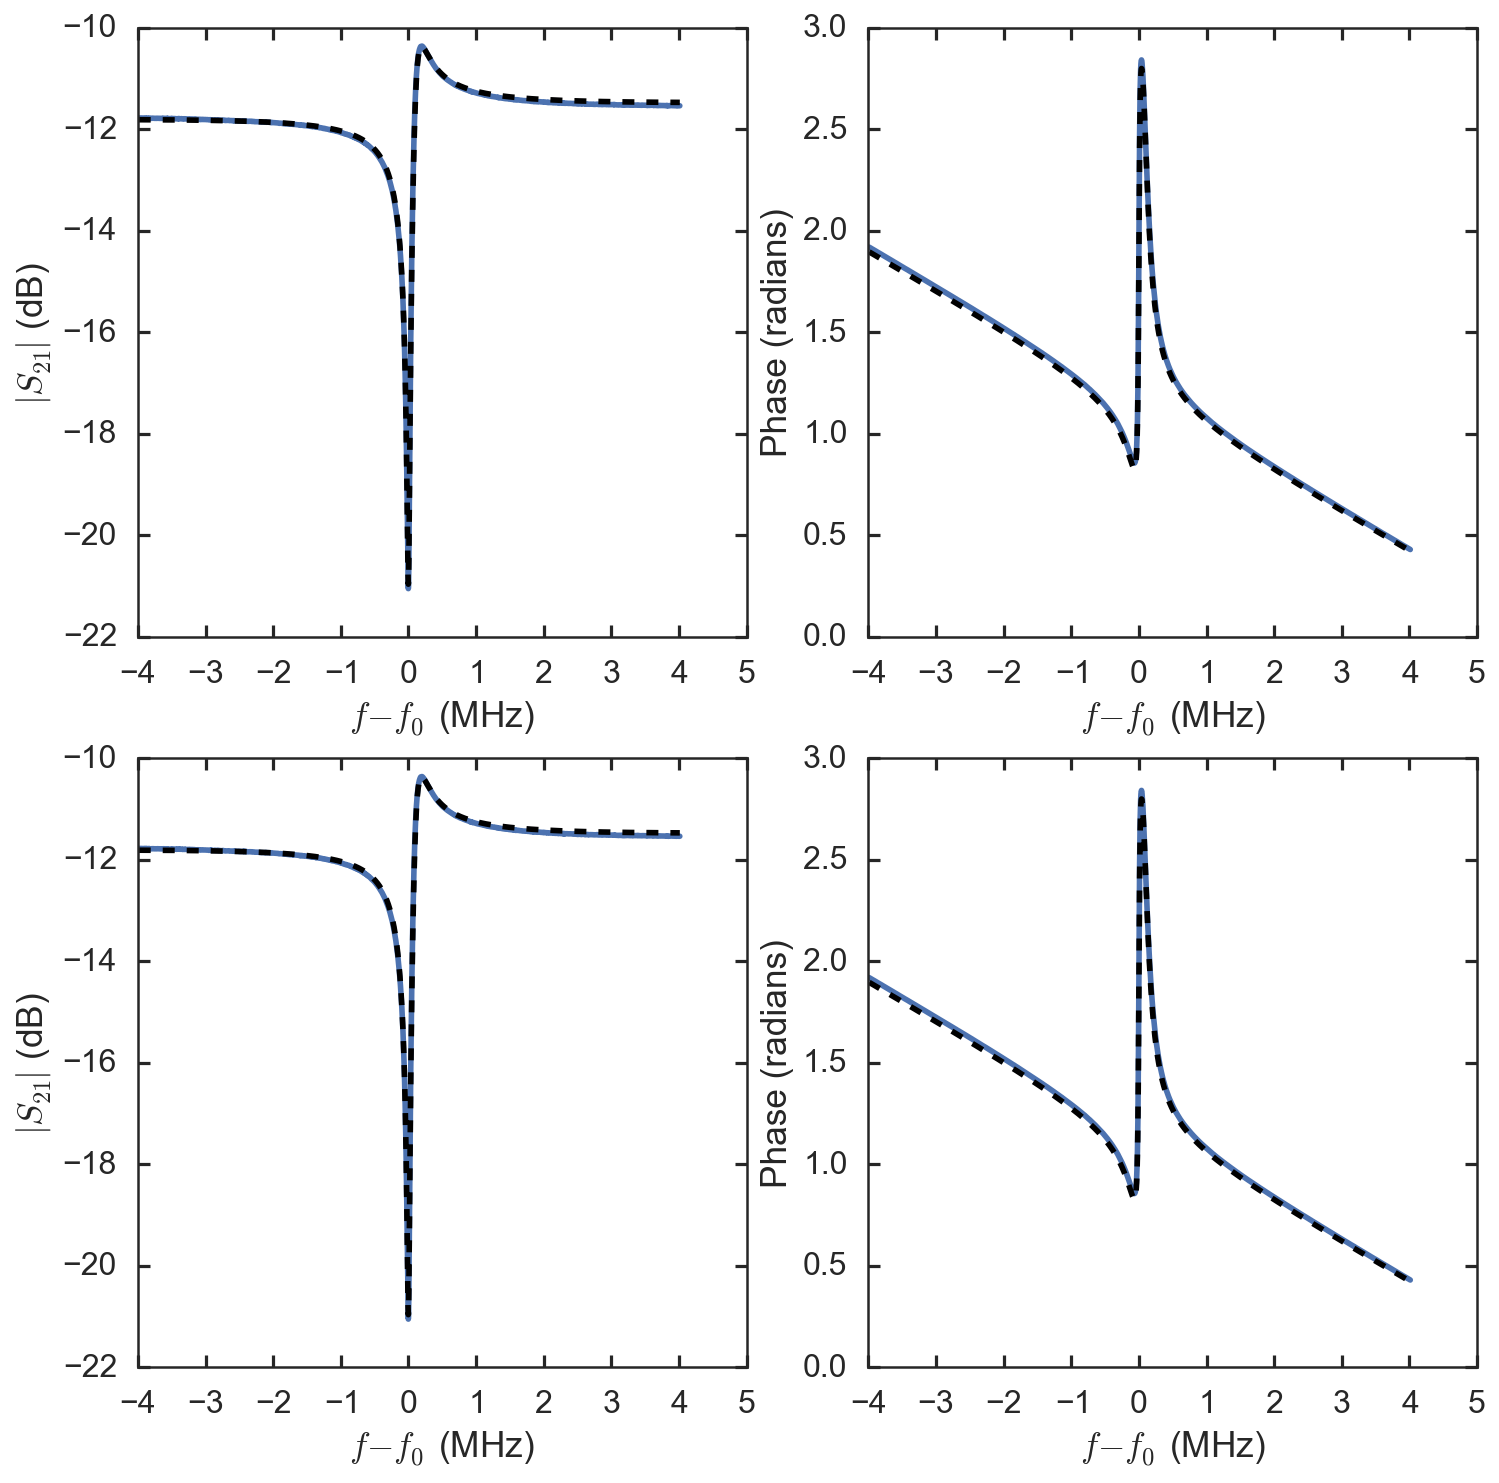

In [7]:
#Set up a figure to overlay the |S21| fit and data
figA = plt.figure()
figA.set_size_inches(12,12)

#Plot the first fit here
axMag1 = figA.add_subplot(221)
axPhase1 = figA.add_subplot(222)

#plot the second fit here
axMag2 = figA.add_subplot(223)
axPhase2 = figA.add_subplot(224)

#Here we will plot against f-f0
axMag1.plot((resObj1.freq-resObj1.S21result.params['f0'].value)*1e-6,10*np.log10(resObj1.mag))
axMag1.plot((resObj1.freq-resObj1.S21result.params['f0'].value)*1e-6,10*np.log10(resObj1.resultMag), 'k--')

axPhase1.plot((resObj1.freq-resObj1.S21result.params['f0'].value)*1e-6,resObj1.phase)
axPhase1.plot((resObj1.freq-resObj1.S21result.params['f0'].value)*1e-6,resObj1.resultPhase, 'k--')

axMag2.plot((resObj2.freq-resObj2.S21result.params['f0'].value)*1e-6,10*np.log10(resObj2.mag))
axMag2.plot((resObj2.freq-resObj2.S21result.params['f0'].value)*1e-6,10*np.log10(resObj2.resultMag), 'k--')

axPhase2.plot((resObj2.freq-resObj2.S21result.params['f0'].value)*1e-6,resObj2.phase)
axPhase2.plot((resObj2.freq-resObj2.S21result.params['f0'].value)*1e-6,resObj2.resultPhase, 'k--')

        
axMag1.set_xlabel('$f-f_0$ (MHz)')
axMag1.set_ylabel('$|S_{21}|$ (dB)')

axMag2.set_xlabel('$f-f_0$ (MHz)')
axMag2.set_ylabel('$|S_{21}|$ (dB)')

axPhase1.set_xlabel('$f-f_0$ (MHz)')
axPhase1.set_ylabel('Phase (radians)')

axPhase2.set_xlabel('$f-f_0$ (MHz)')
axPhase2.set_ylabel('Phase (radians)')

In [ ]:
#Save that figure in the local directory. You worked hard for it!
figA.savefig('Mag-and-Phase-E1.png')

Exercise 1.1:
-----
Write a `process_file` replacement that will allow you to run your data through this notebook. Add it to the repository so that other people can use it too! Your function should generate a dictionary that is identical to the one we call `filedataDict` in this notebook.

Exercise 1.2:
-----
Write some code that extracts all of the fit parameter best-fit values for the two `Resonator` objects, along with their errors and writes it out to the screen in a nice way. Once you've done this, you can try varying parameter guesses in your call to `lmfitRes` to see how they affect the final fit. You'll want to read up a bit on `lmfit` `Parameters` objects and how to access them. Each `Resonator` object contains an attribute called .S21result.params that contains the best fit values, and an attribute called .params that contains the original guesses.